#  Heart rhythm classification from raw ECG signals

## Notes
Interesting insights from Nature paper published on 21.9.2021
- https://www.nature.com/articles/s41598-021-97118-5?proof=t%3B#Tab6
- https://www.youtube.com/watch?v=3tfin4sSBFQ
- Focus on only two features PR and RT.
- MLP and SVM


In [1]:
import pandas as pd
import numpy as np
import neurokit2 as nk
import biosppy.signals.ecg as ecg
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import FeatureUnion
import seaborn as sns
import matplotlib.pyplot as plt
sns.set('talk')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
%matplotlib inline

## Params

In [9]:
sr = 300 #sampling rate

downsampling=True
trim_beginning=True
# sampling rate needs adjustment if downsampling is applied
sampling_divisor = 2 # default: reduce sampling frequency by factor 2
sr_down = sr/sampling_divisor

# Some matplotlib setting 
plt.rcParams['figure.figsize'] = (30, 20)
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 32
#plt.rcParams['axes.labelsize'] = 48
#plt.rcParams['axes.titlesize'] = 48

## Read data

In [3]:
path = '/home/rapwag01/eth/aml/task2/'

In [4]:
df_train = pd.read_csv(path+'X_train.csv')

In [5]:
df_test = pd.read_csv(path+'X_test.csv')

In [6]:
df_target = pd.read_csv(path+'y_train.csv')

In [7]:
df_train.head()

,id,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50,x51,x52,x53,x54,x55,x56,x57,x58,x59,x60,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100,x101,x102,x103,x104,x105,x106,x107,x108,x109,x110,x111,x112,x113,x114,x115,x116,x117,x118,x119,x120,x121,x122,x123,x124,x125,x126,x127,x128,x129,x130,x131,x132,x133,x134,x135,x136,x137,x138,x139,x140,x141,x142,x143,x144,x145,x146,x147,x148,x149,x150,x151,x152,x153,x154,x155,x156,x157,x158,x159,x160,x161,x162,x163,x164,x165,x166,x167,x168,x169,x170,x171,x172,x173,x174,x175,x176,x177,x178,x179,x180,x181,x182,x183,x184,x185,x186,x187,x188,x189,x190,x191,x192,x193,x194,x195,x196,x197,x198,x199,x200,x201,x202,x203,x204,x205,x206,x207,x208,x209,x210,x211,x212,x213,x214,x215,x216,x217,x218,x219,x220,x221,x222,x223,x224,x225,x226,x227,x228,x229,x230,x231,x232,x233,x234,x235,x236,x237,x238,x239,x240,x241,x242,x243,x244,x245,x246,x247,x248,...,x17592,x17593,x17594,x17595,x17596,x17597,x17598,x17599,x17600,x17601,x17602,x17603,x17604,x17605,x17606,x17607,x17608,x17609,x17610,x17611,x17612,x17613,x17614,x17615,x17616,x17617,x17618,x17619,x17620,x17621,x17622,x17623,x17624,x17625,x17626,x17627,x17628,x17629,x17630,x17631,x17632,x17633,x17634,x17635,x17636,x17637,x17638,x17639,x17640,x17641,x17642,x17643,x17644,x17645,x17646,x17647,x17648,x17649,x17650,x17651,x17652,x17653,x17654,x17655,x17656,x17657,x17658,x17659,x17660,x17661,x17662,x17663,x17664,x17665,x17666,x17667,x17668,x17669,x17670,x17671,x17672,x17673,x17674,x17675,x17676,x17677,x17678,x17679,x17680,x17681,x17682,x17683,x17684,x17685,x17686,x17687,x17688,x17689,x17690,x17691,x17692,x17693,x17694,x17695,x17696,x17697,x17698,x17699,x17700,x17701,x17702,x17703,x17704,x17705,x17706,x17707,x17708,x17709,x17710,x17711,x17712,x17713,x17714,x17715,x17716,x17717,x17718,x17719,x17720,x17721,x17722,x17723,x17724,x17725,x17726,x17727,x17728,x17729,x17730,x17731,x17732,x17733,x17734,x17735,x17736,x17737,x17738,x17739,x17740,x17741,x17742,x17743,x17744,x17745,x17746,x17747,x17748,x17749,x17750,x17751,x17752,x17753,x17754,x17755,x17756,x17757,x17758,x17759,x17760,x17761,x17762,x17763,x17764,x17765,x17766,x17767,x17768,x17769,x17770,x17771,x17772,x17773,x17774,x17775,x17776,x17777,x17778,x17779,x17780,x17781,x17782,x17783,x17784,x17785,x17786,x17787,x17788,x17789,x17790,x17791,x17792,x17793,x17794,x17795,x17796,x17797,x17798,x17799,x17800,x17801,x17802,x17803,x17804,x17805,x17806,x17807,x17808,x17809,x17810,x17811,x17812,x17813,x17814,x17815,x17816,x17817,x17818,x17819,x17820,x17821,x17822,x17823,x17824,x17825,x17826,x17827,x17828,x17829,x17830,x17831,x17832,x17833,x17834,x17835,x17836,x17837,x17838,x17839,x17840,x17841
0,0,-64,-66,-69,-72,-75,-77,-80,-86,-89,-83,-70,-51,-21,34,112,227,360,450,481,452,362,228,108,25,-1,-8,-12,-14,-17,-21,-28,-35,-42,-50,-57,-67,-76,-80,-81,-82,-82,-82,-82,-82,-83,-84,-84,-83,-79,-74,-70,-66,-62,-59,-55,-51,-47,-43,-41,-39,-37,-36,-34,-33,-32,-30,-29,-26,-23,-20,-16,-13,-9,-6,-4,0,2,6,12,23,35,48,59,68,76,85,94,102,109,115,122,129,135,142,150,162,180,192,204,215,225,233,239,242,242,235,225,208,187,168,147,125,98,73,54,39,27,19,11,3,-3,-7,-9,-12,-14,-17,-19,-22,-24,-26,-28,-30,-32,-34,-35,-36,-39,-45,-51,-51,-46,-39,-30,-20,-16,-14,-14,-13,-12,-11,-10,-9,-9,-8,-7,-6,-5,-4,-3,-2,0,3,12,29,52,88,135,189,243,296,334,348,353,349,340,331,322,312,300,266,203,138,88,51,13,-3,-10,-13,-16,-17,-18,-17,-15,-11,-6,-1,5,15,22,28,33,37,40,41,37,29,20,13,6,0,-4,-7,-6,-3,2,9,22,45,68,93,121,149,174,189,192,193,195,196,196,196,195,192,187,181,170,149,129,106,77,51,14,-27,-49,-63,-72,-80,-88,-97,-105,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

## 3.0 Delineation Features

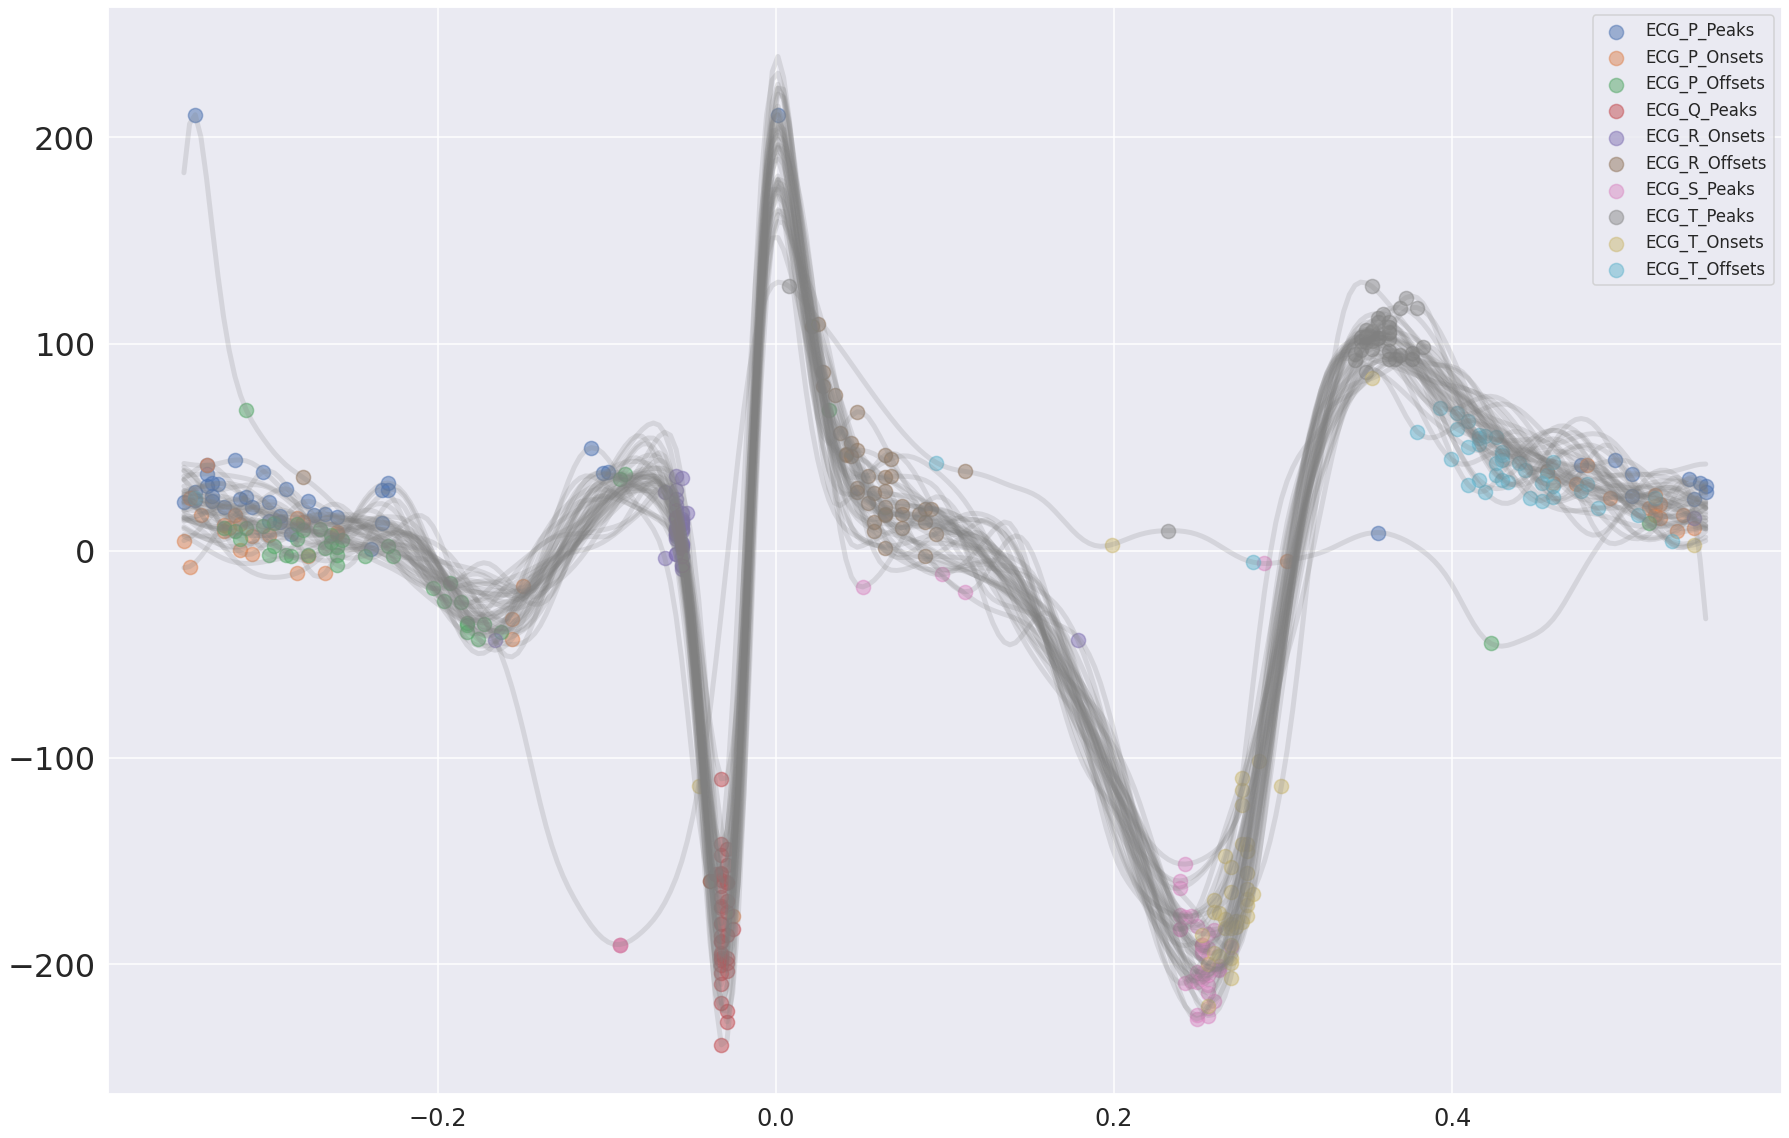

In [11]:
# next to R-peaks, extract P, Q, S and T peaks to get their amplitudes
# use different methods: peak, cwt or dwt
# use wavelet methods to extract QRS on and offsets
_, waves_peak = nk.ecg_delineate(signal_clean, rpeaks, sampling_rate=sr, method="dwt", show=True, show_type='all')

### extract features v0
- stats on amplitudes for each peak
- stats on amplitudes for each onset
- stats on time value for each peak
- stats on time value for each onset (when does P wave start?)

### extract features v1
- aggregate all beat templates (# beats / sample differs): mean, median, std of templates -> aggregated template as a feature in addition


https://ecgwaves.com/topic/ecg-normal-p-wave-qrs-complex-st-segment-t-wave-j-point/

In [14]:
# remove nans
waves_peak_nonan = {k:[elem for elem in v if elem is not np.nan] for k,v in waves_peak.items()}

In [15]:
# should all have the same shape/length
# corrected for nan values
ppeaks = waves_peak_nonan['ECG_P_Peaks']
qpeaks = waves_peak_nonan['ECG_Q_Peaks']
speaks = waves_peak_nonan['ECG_S_Peaks']
tpeaks = waves_peak_nonan['ECG_T_Peaks']
ponsets = waves_peak_nonan['ECG_P_Onsets']
toffsets = waves_peak_nonan['ECG_T_Offsets']

In [19]:
if len(rpeaks) != len(ppeaks):
    print('Warning, peak lengths R and P are different.')

P_amplitudes = signal_clean[ppeaks]
Q_amplitudes = signal_clean[qpeaks]
S_amplitudes = signal_clean[speaks]
T_amplitudes = signal_clean[tpeaks]
R_amplitudes = signal_clean[rpeaks]
Pon_amplitude = signal_clean[ponsets]
Toff_amplitude = signal_clean[toffsets]

Warning, peak lengths R and P are different.


### 3.1 Amplitude Features

In [21]:
# aggregate amplitude values
mean_P_amplitude = np.mean(P_amplitudes)
mean_Q_amplitude = np.mean(Q_amplitudes)
mean_S_amplitude = np.mean(S_amplitudes)
mean_T_amplitude = np.mean(T_amplitudes)
mean_R_amplitude = np.mean(R_amplitudes)

median_P_amplitude = np.median(P_amplitudes)
median_Q_amplitude = np.median(Q_amplitudes)
median_S_amplitude = np.median(S_amplitudes)
median_T_amplitude = np.median(T_amplitudes)
median_R_amplitude = np.median(R_amplitudes)

std_P_amplitude = np.std(P_amplitudes)
std_Q_amplitude = np.std(Q_amplitudes)
std_S_amplitude = np.std(S_amplitudes)
std_T_amplitude = np.std(T_amplitudes)
std_R_amplitude = np.std(R_amplitudes)

max_P_amplitude = np.max(P_amplitudes)
max_Q_amplitude = np.max(Q_amplitudes)
max_S_amplitude = np.max(S_amplitudes)
max_T_amplitude = np.max(T_amplitudes)
max_R_amplitude = np.max(R_amplitudes)

min_P_amplitude = np.min(P_amplitudes)
min_Q_amplitude = np.min(Q_amplitudes)
min_S_amplitude = np.min(S_amplitudes)
min_T_amplitude = np.min(T_amplitudes)
min_R_amplitude = np.min(R_amplitudes)

#these are amplitudes - useless?
mean_pon = np.mean(Pon_amplitude)
median_pon = np.median(Pon_amplitude)
std_pon = np.std(Pon_amplitude)
max_pon = np.max(Pon_amplitude)
min_pon = np.min(Pon_amplitude)

mean_toff = np.mean(Toff_amplitude)
median_toff = np.median(Toff_amplitude)
std_toff = np.std(Toff_amplitude)
max_toff = np.max(Toff_amplitude)
min_toff = np.min(Toff_amplitude)

### 3.2 Timing Features

In [50]:
# normal rr interval 0.6-1.2s
rr_interval = np.diff(rpeaks)/sr*1000 # rr interval in ms

mean_rr_interval = np.mean(rr_interval)
median_rr_interval = np.median(rr_interval)
std_rr_interval = np.std(rr_interval)
max_rr_interval = np.max(rr_interval)
min_rr_interval = np.min(rr_interval)

# pp interval - corrected for nans
pp_interval = np.diff(ppeaks)/sr*1000 # rr interval in ms

mean_pp_interval = np.mean(pp_interval)
median_pp_interval = np.median(pp_interval)
std_pp_interval = np.std(pp_interval)
max_pp_interval = np.max(pp_interval)
min_pp_interval = np.min(pp_interval)

## TO VERIFY IF THIS REALLY IS QRS DURATION!
# qrs duration r-onset minus r onset
qrs_duration = (np.array(waves_peak['ECG_R_Offsets'])-np.array(waves_peak['ECG_R_Onsets']))/sr*1000 # in ms
qrs_duration = qrs_duration[~np.isnan(qrs_duration)]
assert (qrs_duration>0).all()
qrs_mean = np.mean(qrs_duration)
qrs_median = np.median(qrs_duration)
qrs_std = np.std(qrs_duration)
qrs_max = np.max(qrs_duration)
qrs_min = np.min(qrs_duration)

# normal p wave duration 0.12-0.22s
p_duration = (np.array(waves_peak['ECG_P_Offsets'])-np.array(waves_peak['ECG_P_Onsets']))/sr*1000 # in ms
p_duration = p_duration[~np.isnan(p_duration)]
assert (p_duration>0).all()
p_mean = np.mean(p_duration)
p_median = np.median(p_duration)
p_std = np.std(p_duration)
p_max = np.max(p_duration)
p_min = np.min(p_duration)

# pr segment
pr_duration = (np.array(waves_peak['ECG_R_Onsets'])-np.array(waves_peak['ECG_P_Onsets']))/sr*1000 # in ms
pr_duration = pr_duration[~np.isnan(pr_duration)]
assert (pr_duration>0).all()
pr_mean = np.mean(pr_duration)
pr_median = np.median(pr_duration)
pr_std = np.std(pr_duration)
pr_max = np.max(pr_duration)
pr_min = np.min(pr_duration)

# R time
# time from R onset to R peak, R_onset seems to be the QRS onset: https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.ecg_delineate%3E
rwave_peaktime = rpeaks-waves_peak['ECG_R_Onsets']
rwave_peaktime = rwave_peaktime[~np.isnan(rwave_peaktime)]
assert (rwave_peaktime>0).all()
rwave_mean = np.mean(rwave_peaktime)
rwave_median = np.median(rwave_peaktime)
rwave_std = np.std(rwave_peaktime)
rwave_max = np.max(rwave_peaktime)
rwave_min = np.min(rwave_peaktime)

---

## 2.0 Customised Transformers for Pipeline

In [214]:
#Function or class to extract features from ALL samples
#For each sample:
#1) process (clean and filter)
#2) extract heartbeats from clean signal
#    - 180 timestep features for each  beat variable
#    - mean, median, std,
#3) delineate
#4) extract amplitude features
#5) extract timing features
#6) extract hrv
#7) use in feature union

#1. Preprocessing Transformer
#2. Heartbeat Feature Extractor
#3. Delineation Extractor
#4. HRV Extractor

In [93]:
class MyCleaning(BaseEstimator, TransformerMixin):
    
    def __init__(self, sampling_rate, detrend_method='locreg', filter_method='neurokit', \
                 trim_beginning=True, downsampling=True, skip_num_samples=540, sampling_divisor=2):
        
        self.sr = sampling_rate
        self.detrend_method = detrend_method
        self.filter_method = filter_method
        self.order = -1
        self.trim_beginning = trim_beginning
        self.downsampling = downsampling
        self.sampling_divisor = sampling_divisor
        self.skip_num_samples = skip_num_samples
        
        if self.detrend_method == 'constant':
            self.order = 0
        elif self.detrend_method == 'linear':
            self.order = 1
        elif self.detrend_method == 'quadratic':
            self.order = 2
        elif self.detrend_method == 'cubic':
            self.order = 3
        elif self.detrend_method == 'poly10':
            self.order = 10
        elif self.detrend_method == 'trav':
            self.detrend_method='tarvainen2002'      
        elif self.detrend_method == 'loess':
            self.detrend_method = 'loess'


    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        """np.apply_along_axis is slower than for loop.
        Keeping for loop.
        Input X should be numpy array, not pd series. Trying to be consistent with sklearn.
        """
        
        if self.trim_beginning:
            X = self._trim_beginning(X)
            
        if self.downsampling:
            print(f'You are downsampling data by a factor {self.sampling_divisor}. Be aware to adjust sampling frequency for subsequent transformers!')
            X = self._downsampling(X)

        clean_signals = []
        for sample in np.arange(X.shape[0]):
            
            if sample % 500 == 0:
                print(f'cleaning sample {sample}')
            
            # drop nans 
            ecg_nonans = X[sample][~np.isnan(X[sample])]
            clean = self._cleaning(ecg_nonans)
            
            # pad array with nans to match previous dimensions
            pad_width = X[sample].shape[0]-clean.shape[0]           
            cleaned_padded = np.pad(clean, pad_width=(0, pad_width), mode='constant', constant_values=np.nan)           
            clean_signals.append(cleaned_padded)
            
        return np.stack(clean_signals)
    
    def _trim_beginning(self, X, skip_num_samples=540):
        """Trim signal at begining and skip n first samples given by skip_num_samples.
        Applied before downsampling if downsampling=True.
        By default skips ~3 heartbeats, i.e. 3x180 samples, where 180 corresponds to the heartbeat extraction
        sample size."""
        X_trimmed = X[:,skip_num_samples:]
        assert X_trimmed.shape[0] == X.shape[0]
        assert X_trimmed.shape[1] == X.shape[1]-skip_num_samples
        
        return X_trimmed
    
    def _downsampling(self, X, sampling_divisor=2):
        """Selects every n-th (sampling_divisor) timestep.
        By default cuts sampling rate into two."""
        X_downsampled = X[:,::sampling_divisor]
        assert X_downsampled.shape[0] == X.shape[0]
        assert X_downsampled.shape[1] == X.shape[1]/sampling_divisor
        return X_downsampled
    
    def _cleaning(self, raw_ecg):
        """
        For detrending: https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.signal.signal_detrend
        For filtering: https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.ecg.ecg_clean
        """

        detrended = nk.signal_detrend(raw_ecg, order=self.order, method=self.detrend_method, \
                                      window=1.5*100, stepsize=0.02*100)        

        if self.filter_method == 'custom_butterworth':
            cleaned = nk.signal_filter(detrended, sampling_rate=self.sr, lowcut=2, highcut=9, method='butterworth')
        else:
             # ecg_clean only applies filtering, no detrending
            cleaned = nk.ecg_clean(detrended, sampling_rate=self.sr, method=self.filter_method)

        return cleaned

In [94]:
cleaner = MyCleaning(sampling_rate=sr, downsampling=downsampling, trim_beginning=trim_beginning)

In [13]:
data = df_train.drop('id', axis=1)

In [54]:
t = data[:5]

In [446]:
%%time
new = cleaner.fit_transform(data)

cleaning sample 0
cleaning sample 500
cleaning sample 1000
cleaning sample 1500
cleaning sample 2000
cleaning sample 2500
cleaning sample 3000
cleaning sample 3500
cleaning sample 4000
cleaning sample 4500
cleaning sample 5000
CPU times: user 18min 39s, sys: 1.53 s, total: 18min 40s
Wall time: 18min 39s


In [95]:
newt = cleaner.fit_transform(t.values)

You are downsampling data by a factor 2. Be aware to adjust sampling frequency for subsequent transformers!
cleaning sample 0


In [27]:
class MyHeartBeatExtractor(BaseEstimator, TransformerMixin):
    """Extracts heartbeats for each cleaned sample separately (num beats x length template).
    Each feature is an aggregation over different heartbeats extracted and has dim of the standard length of one beat (tempalte).
    Template length is the same for all samples but number of beats extracted changes.
    We need to average over number of heartbeats extracted.
    Extracted features correspond to aggregated heartbeat templates for each sample, e.g. if template length is 180, 
    mean beat is an 180-step averaged timeseries, max beat is the maximum amplitude at 180 different timesteps, etc.
    
    """
    def __init__(self, sampling_rate):
        self.sr = sampling_rate
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        features = []
        #features = np.apply_along_axis(self.cleaning, 1, X)
        #_, rpeaks = np.apply_along_axis(self._get_rpeaks(sample_clean)

        for id_clean in np.arange(X.shape[0]):
            if id_clean % 500 == 0:
                print(f'extracting features from sample {id_clean}')
            
            sample_features = self._get_features_from_sample(X[id_clean])
            
            # list of list of (180,) arrays
            features.append(sample_features)
        
        # should return X_new (num_samples, num_features)
        return np.stack(features)

    def _get_rpeaks(self, ecg_cleaned):
        instant_peaks, rpeaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=self.sr)
        return instant_peaks, rpeaks
    
    def _get_heartrate(self, rpeaks, ecg_cleaned):
        rate = nk.ecg_rate(rpeaks, sampling_rate=self.sr, desired_length=len(ecg_cleaned))
        return rate
    
    def _get_features_from_sample(self, ecg_cleaned):
        """Returns a list of aggregated heartbeat features for each sample"""

        ecg_nonans = ecg_cleaned[~np.isnan(cg_cleaned)]
        _, rpeaks = self._get_rpeaks(ecg_nonans)
        heartrates = self._get_heartrate(rpeaks, ecg_nonans)
        beats = ecg.extract_heartbeats(ecg_nonans, rpeaks, self.sr)['templates']

        # aggregate over heartbeats
        mean_beat = np.mean(beats, axis=0) # average over beats with shape (num beats x standard length per beat) to get mean with dim (length per beat)
        median_beat = np.median(beats, axis=0) # shape (standard heartbeat length,)
        std_beat = np.std(beats, axis=0)
        max_beat = np.max(beats, axis=0)
        min_beat = np.min(beats, axis=0)
        
        # list of (180,) arrays
        sample_features = [heartrates, mean_beat, median_beat, std_beat, max_beat, min_beat]
        
        return sample_features

In [28]:
# adjust sampling frequency
extractor = MyHeartBeatExtractor(sampling_rate=sr_down)

In [29]:
# cleaned signal with adjusted sample size (downsampled and trimmed)
newt.shape
newt[0]


array([39.17395078, 37.18927707, 35.03712902, ...,         nan,
               nan,         nan])

In [30]:
# extract features from clean signal
hb_feat = extractor.fit_transform(newt)

extracting features from sample 0


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [ ]:
class MyDelineationExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, sampling_rate, delineation_method):
        self.sr = sampling_rate
        self.delineation_method = delineation_method
           
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return 
    
    
    def _get_wavepeaks(self, ecg_cleaned):
        ecg_nonans = ecg_cleaned[~np.isnan(ecg_cleaned)]
        
        _, waves_peak = nk.ecg_delineate(signal_clean, rpeaks, sampling_rate=self.sr, \
                                         method=self.delineation_method, show=False, show_type='all')
        waves_peak_nonan = {k:[elem for elem in v if elem is not np.nan] for k,v in waves_peak.items()}
        
        
        # should all have the same shape/length
        # corrected for nan values
        ppeaks = waves_peak_nonan['ECG_P_Peaks']
        qpeaks = waves_peak_nonan['ECG_Q_Peaks']
        speaks = waves_peak_nonan['ECG_S_Peaks']
        tpeaks = waves_peak_nonan['ECG_T_Peaks']
        ponsets = waves_peak_nonan['ECG_P_Onsets']
        toffsets = waves_peak_nonan['ECG_T_Offsets']
        
        
        
        

In [472]:
class MyHRVExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, sampling_rate):
        self.sr = sampling_rate    
    
    def _get_hrv(self, ecg_cleaned):
        
        ecg_nonans = ecg_cleaned[~np.isnan(ecg_cleaned)]
        _, rpeaks = nk.ecg_peaks(ecg_nonans, sampling_rate=self.sr)
        
        df_hrv = nk.hrv(rpeaks, sampling_rate=self.sr)
        df_hrv.dropna(axis=1, inplace=True)
        
        return df_hrv.values
    
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        hrvs = []
        for id_clean in np.arange(X.shape[0]):
            if id_clean % 500 == 0:
                print(f'extracting features from sample {id_clean}')
            
            sample_clean = X[id_clean]
            
            hrv = self._get_hrv(sample_clean)
            print(hrv)
            hrvs.append(hrv)  
        print(hrvs)
        return np.stack(hrvs)

In [473]:
myhrv = MyHRVExtractor(sampling_rate=sr)

In [470]:
newt.shape

(3, 17842)

In [474]:
hrvt = myhrv.transform(newt)

extracting features from sample 0
[[ 8.15846154e+02  6.58966751e+01  6.42099421e+01  6.42237601e+01
   8.07709577e-02  7.87034931e-02  8.30000000e+02  1.48260000e+01
   1.78626506e-02  2.33333333e+01  1.53846154e+00  4.61538462e+00
   3.82352941e+00  5.23437500e+02  8.42798962e-03  4.72863509e-03
   3.66993195e-04  1.78233031e+00  6.23205246e-01  3.49657549e-01
  -5.35411868e+00  4.54130563e+01  5.33531709e+01  8.51178205e-01
   7.61186082e+03  1.17484211e+00  4.58846095e+00  2.50726208e+02
   6.61538462e-01  6.66666667e-01  9.21052632e-01  2.35294118e-01
   7.45161290e+01  7.81461667e+01  7.15973068e+01  4.91228070e+01
   9.87409466e-01  1.25905339e-02  4.54732125e+01  5.13486543e+00
   8.48544958e-01  1.51455042e-01  4.91470737e+01  2.07635737e+01
   9.07403999e-01  9.25960011e-02  4.73457913e+01  1.51243650e+01
   1.38856713e+00  2.50664381e-01  1.47977805e+00  7.85644436e-01
   8.72464205e-01  5.26582569e-01  4.29562660e-01  4.13209056e+00
   3.83726197e-01  4.04225380e-01  1.71061

/home/rapwag01/.virtualenvs/vethaml/lib/python3.8/site-packages/neurokit2/hrv/hrv_nonlinear.py:486: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `windows` argument in `nk.fractal_dfa()` for more information.
  warn(
/home/rapwag01/.virtualenvs/vethaml/lib/python3.8/site-packages/neurokit2/complexity/entropy_multiscale.py:202: RuntimeWarning: invalid value encountered in double_scalars
  mse = np.trapz(mse) / len(mse)
/home/rapwag01/.virtualenvs/vethaml/lib/python3.8/site-packages/neurokit2/complexity/optim_complexity_k.py:83: NeuroKitWarning: The optimal kmax value detected is 2 or less. There may be no plateau in this case. You can inspect the plot by set `show=True`. We will return optimal k_max = 32 (the max).
  warn(
/home/rapwag01/.virtualenvs/vethaml/lib/python3.8/site-packages/neurokit2/hrv/hrv_nonlinear.py:486: NeuroKitW

[[ 7.89047619e+02  5.23036098e+01  5.52090501e+01  5.60321506e+01
   6.62870131e-02  6.99692247e-02  8.00000000e+02  4.44780000e+01
   5.55975000e-02  6.33333333e+01  8.57142857e+00  6.85714286e+01
   8.75000000e+00  2.26562500e+02  2.49891762e-02  1.07598368e-02
   6.99017235e-01 -3.68931250e+00  3.96207137e+01  6.31420086e+01
   6.27485798e-01  7.85942112e+03  1.59366157e+00  4.60236067e+00
   4.02507969e+02  4.57142857e-01  5.00000000e-01  6.47058824e-01
   0.00000000e+00  5.12195122e+01  5.10063238e+01  5.14160567e+01
   5.00000000e+01  6.07162003e-01  3.92837997e-01  3.08766417e+01
   2.48361635e+01  4.61691362e-01  5.38308638e-01  4.29036526e+01
   4.63269882e+01  5.02795115e-01  4.97204885e-01  3.73770679e+01
   3.71687023e+01  9.22860636e-01  8.99425942e-01  8.47867070e-01
   1.56924151e+00  5.24370730e-01  3.24364763e-01  1.15267951e+00
   4.65057195e+00  1.14466925e+00  1.20722155e+00  1.71630304e+00
   1.93728770e+00  1.17240755e+00]]
[[ 9.00689655e+02  3.59163414e+01  2.653

/home/rapwag01/.virtualenvs/vethaml/lib/python3.8/site-packages/neurokit2/hrv/hrv_nonlinear.py:486: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `windows` argument in `nk.fractal_dfa()` for more information.
  warn(
/home/rapwag01/.virtualenvs/vethaml/lib/python3.8/site-packages/neurokit2/complexity/entropy_multiscale.py:202: RuntimeWarning: invalid value encountered in double_scalars
  mse = np.trapz(mse) / len(mse)


ValueError: all input arrays must have the same shape

In [ ]:
union = FeatureUnion([('heartbeat', MyHeartBeatExtractor()),
                     ('delineation', MyDelineationExtractor()),
                     ('hrv', MyHRVExtractor())])

In [ ]:
pipeline = Pipeline(
    ('preprocessing', MyPreprocessing),
    ('feature_extraction')
    ('selector', SelectKBest),
    ('umap', ),
    ('classifier', RF with weights)
    )

---

In [ ]:
# custom transformer to two two step classification (class 3 vs all first)
class MyOutlierDetection():

---